In [1]:
#UNI- bs3118
#import statements
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
import zipfile

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/Users/bhavyashahi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


The dataset is split into training, testing and validation. We use InceptionResNet network as the second application. The accuracy achieved for validation is 95.26%. The testing data gives a 98.03% accuracy. The Inception network has about 61 million parameters which is very large compared to MobileNet which gives us a comparable accuracy and has far fewer parameters.
The other two notebooks contain code for MobileNet and VGG.

In [ ]:
#code to download the dataset zip from my Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

!unzip "/content/gdrive/My Drive/Colab Notebooks/dataset.zip"

In [16]:
base_dir = '/content/dataset/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

train_alma_dir = os.path.join(train_dir, 'alma')
train_lion_dir = os.path.join(train_dir, 'lion')
train_thinker_dir = os.path.join(train_dir, 'thinker')


validation_alma_dir = os.path.join(validation_dir, 'alma')
validation_lion_dir = os.path.join(validation_dir, 'lion')
validation_thinker_dir = os.path.join(validation_dir, 'thinker')

test_alma_dir = os.path.join(test_dir, 'alma')
test_lion_dir = os.path.join(test_dir, 'lion')
test_thinker_dir = os.path.join(test_dir, 'thinker')


num_alma_tr = len(os.listdir(train_alma_dir))
num_lion_tr = len(os.listdir(train_lion_dir))
num_thinker_tr = len(os.listdir(train_thinker_dir))

num_alma_test = len(os.listdir(test_alma_dir))
num_lion_test = len(os.listdir(test_lion_dir))
num_thinker_test = len(os.listdir(test_thinker_dir))

num_alma_val = len(os.listdir(validation_alma_dir))
num_lion_val = len(os.listdir(validation_lion_dir))
num_thinker_val = len(os.listdir(validation_thinker_dir))


total_train = num_alma_tr + num_lion_tr + num_thinker_tr 
total_val = num_alma_val + num_lion_val + num_thinker_val 
total_test = num_alma_test + num_lion_test + num_thinker_test 

print('Training alma images:', num_alma_tr)
print('Training lion images:', num_lion_tr)
print('Training thinker images:', num_thinker_tr)

print('Test alma images:', num_alma_test)
print('Test lion images:', num_lion_test)
print('Test thinker images:', num_thinker_test)

print('Validation alma images:', num_alma_val)
print('Validation lion images:', num_lion_val)
print('Validation thinker images:', num_thinker_val)


print("Total training images:", total_train)
print("Total validation images:", total_val)
print("Total test images:", total_test)

Training alma images: 357
Training lion images: 436
Training thinker images: 301
Test alma images: 149
Test lion images: 182
Test thinker images: 126
Validation alma images: 89
Validation lion images: 109
Validation thinker images: 76
Total training images: 1094
Total validation images: 274
Total test images: 457


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 3, 3, 1536)        54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 13824)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               7078400   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1539      
Total params: 61,416,675
Trainable params: 61,356,131
Non-trainable params: 60,544
_________________________________________________________________
Found 1093 images belonging to 3 classes.
Found 274 images belonging to 3 classes.
Epoch 1/30
 - 120s - loss: 1.4852 - acc: 0.6757 - val_loss: 0.5197 - val_acc: 0.8759
Epoch 2/30
 - 85s - loss: 0.1590 - acc: 0.9518 - val_loss: 0.2420 - val_acc: 0.9380
Epoch

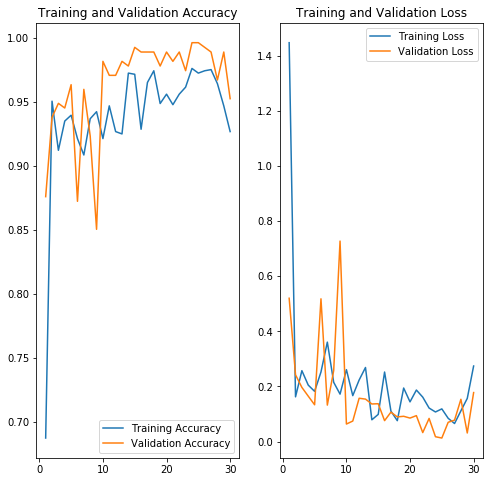

In [12]:
from tensorflow.keras.applications import InceptionResNetV2
#We use Inception as the base convolution net
conv_base = InceptionResNetV2(include_top=False, weights='imagenet',input_shape=(150,150,3), classes=3)
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
#changed for 3 classes, and the activation function is changed to sofmax for categorical 
model.add(Dense(3, activation='softmax'))
model.summary()
conv_base.trainable = False
TARGET_SHAPE = 150
BATCH_SIZE = 32
EPOCHS=30
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
#mode is changed to categorical in training and validation
train_data_gen = image_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=train_dir, 
    shuffle=True, 
    target_size=(TARGET_SHAPE,TARGET_SHAPE),
    class_mode='categorical')

# Validation data should not be augmented!
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=validation_dir, 
    target_size=(TARGET_SHAPE, TARGET_SHAPE),
    class_mode='categorical')
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

history = model.fit_generator(
      train_data_gen,
      steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
      epochs=EPOCHS,
      validation_data=val_data_gen,
      validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
      verbose=2)
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
#The test data is used to evaluate the final model .The accuracy achieved is 98%
image_gen_val = ImageDataGenerator(rescale=1./255)
test_data_gen = image_gen_val.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=test_dir, 
    target_size=(TARGET_SHAPE, TARGET_SHAPE),
    class_mode='categorical')
model.evaluate(test_data_gen)

Found 457 images belonging to 3 classes.
15/15 [==============================] - 29s 2s/step


[0.07310381769742695, 0.9803063458634675]